### Imports

In [1]:
# Make necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import choice

In [2]:
# Import machine learning models and utilities
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import SGDOneClassSVM
from sklearn.utils import check_random_state


### Setup

In [3]:
def zero_given_columns(df, column_names):
    df_to_zero = df.copy()
    df_to_zero.loc[:, df_to_zero.columns.isin(column_names)] = 0
    return df_to_zero


In [4]:
def score_competition(edited_df, validation):
    """Simulate the scoring of a submission against the test set
    Return the validation RMSE"""

    y_train = edited_df.pop('target')
    
    rf = RandomForestRegressor(n_estimators=1000,
                               max_depth=7,
                               n_jobs=-1,
                               random_state=42)
    
    rf.fit(edited_df, y_train)
    
    y_va_pred = rf.predict(validation.loc[:, validation.columns != "target"])

    rmse = mean_squared_error(validation.loc[:, "target"], y_va_pred, squared=False)
    
    return rmse

def cross_validate_model(prepare_submission, label):
    """Cross-validate the prepare_submission function
    
    Parameters:
    prepare_submission: function which transforms its argument sample_submission
    into a dataframe for submission
    
    label: label for the final comparison
    """
    rmse_list = []
    kf = KFold(shuffle=True, random_state=3)
    for fold, (idx_tr, idx_va) in enumerate(kf.split(df)):
        edited_df = prepare_submission(df.iloc[idx_tr].copy())
        rmse = score_competition(edited_df, df.iloc[idx_va])
        print(f"# Fold {fold} RMSE: {rmse:.3f}")
        rmse_list.append(rmse)


    # This way of aggregating scores ensures that folds with really bad scores are more visible.
    rmse = np.sqrt(np.square(np.array(rmse_list)).mean())
    print(f"# Overall RMSE: {rmse:.3f} {label}")
    result_list.append([label, rmse] + rmse_list)

In [5]:
# Keep track of all the results, and their notes
result_list = []

In [6]:
org_test = pd.read_csv("archive/test.csv")
org_train = pd.read_csv("archive/train.csv")

In [7]:
# Read the data
df = pd.read_csv("sample_submission.csv")

In [8]:
cross_validate_model(lambda x: x, "No changes") # 1.574 == Baseline

# Fold 0 RMSE: 1.029
# Fold 1 RMSE: 1.283
# Fold 2 RMSE: 0.972
# Fold 3 RMSE: 1.668
# Fold 4 RMSE: 2.284
# Overall RMSE: 1.526 No changes


### Comparison of Original data Outliers to a submission outliers

In [9]:
org_test["O2_2"].nlargest(5)

36    54.000000
39    27.666667
15    20.000000
18    18.700000
17    16.300000
Name: O2_2, dtype: float64

<Axes: xlabel='O2_2', ylabel='O2_1'>

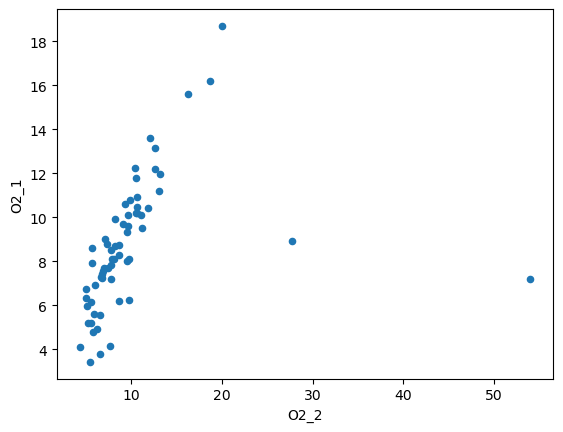

In [10]:
org_test[["O2_2", "O2_1"]].plot.scatter(x="O2_2", y="O2_1")

In [11]:
org_train[(org_train[["O2_1", "O2_2"]] > 30).any(axis=1)]

,Id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,...,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
94,132,7.35,46.950000,7.35,NaN,NaN,NaN,NaN,NaN,0.615000,...,NaN,NaN,NaN,7.600000,5.40,NaN,NaN,NaN,NaN,NaN
98,142,9.10,7.366667,40.90,8.77,6.17,2.28,10.4,7.2,0.246667,...,5.69,3.02,8.32,3.333333,6.95,5.8,5.2,5.5,3.9,3.9


In [12]:
org_train.loc[98]

Id        142.000000
target      9.100000
O2_1        7.366667
O2_2       40.900000
O2_3        8.770000
O2_4        6.170000
O2_5        2.280000
O2_6       10.400000
O2_7        7.200000
NH4_1       0.246667
NH4_2       0.895000
NH4_3       0.714000
NH4_4       7.850000
NH4_5      12.420000
NH4_6       0.210000
NH4_7       0.510000
NO2_1       0.088667
NO2_2       1.360000
NO2_3       0.026000
NO2_4       0.805000
NO2_5       0.934000
NO2_6       0.013000
NO2_7       0.191000
NO3_1       2.346667
NO3_2       5.105000
NO3_3       3.710000
NO3_4       5.240000
NO3_5       5.690000
NO3_6       3.020000
NO3_7       8.320000
BOD5_1      3.333333
BOD5_2      6.950000
BOD5_3      5.800000
BOD5_4      5.200000
BOD5_5      5.500000
BOD5_6      3.900000
BOD5_7      3.900000
Name: 98, dtype: float64

In [13]:
distances = []
for row in df.iterrows():
    # print(row[1])
    # print(np.linalg.norm(org_train.drop(["O2_2", "Id"], axis=1).loc[98] - row[1].drop(["O2_2", "id"])))
    distances.append([row[0], np.linalg.norm(org_train.drop(["O2_2", "Id", "target"], axis=1).loc[98] - row[1].drop(["O2_2", "id", "target"]))])

distances = pd.DataFrame(distances, columns=["id", "distance"])

In [14]:
pd.merge(df, distances, on="id").nsmallest(30, "distance")

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,...,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7,distance
1159,1159,9.12,7.367,8.090,8.770,6.170,2.280,10.070,7.150,0.247,...,2.210,8.320,3.333,6.700,5.800,5.200,5.500,3.500,4.140,2.411854
2425,2425,9.10,7.367,40.900,8.770,6.170,2.280,10.400,7.150,0.247,...,3.020,8.320,3.333,6.950,5.800,5.200,5.500,2.155,2.900,2.863911
2756,2756,9.09,9.100,7.200,7.960,6.170,2.280,10.070,7.150,1.127,...,3.020,8.320,3.333,6.950,5.845,5.200,5.725,3.900,4.450,3.220994
3285,3285,9.11,7.367,40.900,8.770,6.170,2.280,10.440,7.200,0.473,...,3.020,8.320,3.333,6.950,5.800,5.200,5.500,1.570,2.600,3.356764
229,229,9.10,7.367,40.900,8.770,8.370,2.280,11.500,6.375,0.247,...,2.210,8.320,3.333,6.950,3.950,5.200,5.500,3.500,3.170,3.825094
2263,2263,9.09,7.367,40.900,8.770,6.170,2.280,10.400,7.200,0.247,...,3.020,8.320,3.333,6.950,4.725,2.800,5.725,3.913,1.600,4.331277
2288,2288,9.02,7.367,40.900,8.770,6.170,6.015,10.400,7.200,0.447,...,3.020,8.320,3.333,6.950,3.950,6.075,5.845,3.500,3.800,4.794715
979,979,9.10,7.367,40.900,8.770,8.370,2.280,10.070,6.375,0.247,...,3.020,8.320,3.333,6.950,5.800,5.200,5.500,2.155,1.600,4.832217
3129,3129,9.08,7.050,40.900,8.770,6.170,2.280,10.400,5.030,0.247,...,0.636,8.320,3.333,6.950,5.800,5.200,5.500,3.500,3.500,4.994894
898,898,8.65,7.933,8.933,11.475,6.170,2.280,10.070,7.600,0.473,...,1.440,8.320,4.500,6.033,3.500,6.075,5.500,3.967,3.700,5.255678


<Axes: xlabel='O2_1', ylabel='target'>

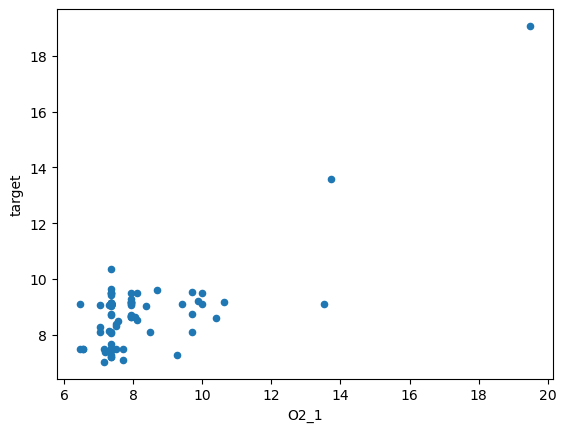

In [15]:
df.loc[(df["O2_2"] == 40.9) & (df.target.between(0, 20)) & (df["O2_1"].between(0, 20)), ["O2_1", "target"]].plot.scatter(x="O2_1", y="target")

<Axes: >

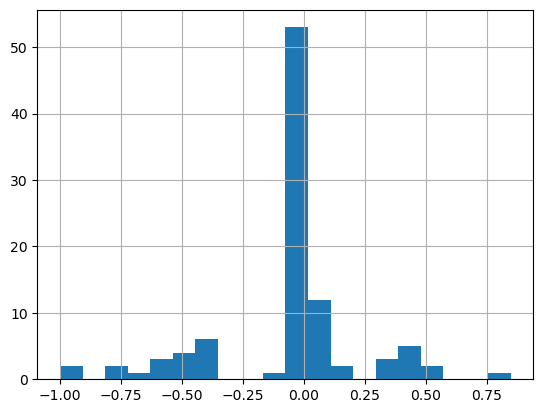

In [16]:
(df.loc[(df["O2_2"] == 40.9) & (df.target.between(8.1, 10.1)), df.columns.isin(["O2_2", "id"]) == False] - org_train.drop(["O2_2", "Id"], axis=1).loc[98]).target.hist(bins=20) #.hist(bins=20)

In [17]:
# First Set of Rules (Making Them more inclusive, may lead to increase in error):
# df.loc[(df["O2_2"] == 40.9) & df["target"].between(7.4, 7.6), "target"] = 7.48
# df.loc[(df["O2_2"] == 40.9) & df["target"].between(8.1, 10.1), "target"] = 9.1

In [18]:
df.loc[(df["O2_2"] == 40.9) & ~(df["target"].between(7.4, 7.6) | df["target"].between(8.1, 10.1))]

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,...,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
211,211,8.08,7.367,40.9,9.000,6.170,2.280,8.430,7.150,0.247,...,2.020,0.636,1.800,2.520,6.95,10.665,6.075,8.415,6.625,7.37
316,316,40.78,40.900,40.9,9.500,6.805,5.010,8.760,6.805,0.490,...,9.805,4.530,4.420,4.800,3.50,4.650,6.025,5.070,3.850,4.14
337,337,7.08,7.695,40.9,9.545,9.115,8.110,8.980,6.375,0.725,...,20.050,9.530,7.695,2.520,1.72,3.950,6.075,8.400,3.500,3.60
457,457,13.58,13.733,40.9,13.900,11.475,2.280,10.440,10.460,0.447,...,5.690,2.420,8.320,3.333,6.95,5.800,5.200,5.200,3.900,10.37
474,474,7.28,7.367,40.9,9.545,7.600,3.290,9.805,5.030,0.410,...,4.580,1.730,2.840,3.150,2.20,3.950,3.950,6.750,3.500,3.90
508,508,7.21,7.350,40.9,7.960,9.265,6.015,9.805,5.030,0.360,...,6.015,1.730,2.840,4.550,4.25,2.040,2.800,8.400,6.625,7.37
982,982,7.66,7.350,40.9,9.545,9.115,6.025,9.805,7.150,0.470,...,4.580,1.730,0.760,2.520,1.72,4.725,6.075,5.725,2.950,4.14
1876,1876,19.94,40.900,40.9,9.545,9.265,3.290,9.805,5.030,0.560,...,17.465,1.730,1.730,4.800,4.95,10.665,10.465,10.465,2.155,2.90
2413,2413,8.09,9.700,40.9,11.475,9.115,6.025,10.070,9.805,0.300,...,4.580,0.636,1.800,4.800,6.54,4.725,6.075,8.415,4.025,3.17
2448,2448,7.02,7.170,40.9,12.700,8.370,2.280,10.070,7.150,0.490,...,2.020,1.730,0.760,5.000,5.40,3.950,6.075,5.725,3.500,3.30


In [19]:
df.loc[df["O2_2"].nlargest(5).index]

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,...,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
451,451,65.93,40.95,65.95,9.265,6.625,5.01,8.37,6.375,0.710,...,7.795,1.73,1.780,4.10,4.645,4.725,5.725,10.645,3.025,3.80
596,596,8.74,9.00,55.45,7.980,7.200,7.24,8.42,7.900,0.230,...,5.070,10.07,27.025,5.05,4.950,3.950,6.625,8.400,3.500,4.45
1050,1050,9.32,7.40,46.95,8.370,6.490,3.29,8.98,7.150,0.247,...,4.650,1.73,1.800,4.90,4.970,2.040,2.800,8.400,2.155,1.83
3073,3073,8.33,8.37,46.95,9.545,9.265,4.58,8.98,5.030,0.180,...,7.795,1.73,1.800,4.95,4.700,7.700,6.075,5.725,8.250,6.34
3305,3305,8.10,8.25,46.95,13.900,9.265,4.55,10.07,6.375,0.240,...,24.220,1.73,1.800,5.10,5.550,7.600,8.700,27.120,8.575,5.20


### Using Duplicate Outliers to Notice Target Values

In [20]:
def make_custom_changes(df):
    df = df.drop(df.index[df.index == 2365])

    # df.loc[df.index.isin([284, 2992]), "O2_2"] = 40.9
    
    # df.loc[df.index.isin([1050]), "O2_2"] = 40.9
    
    df.loc[(df["O2_2"] == 40.9) & df["target"].between(7.4, 7.6), "target"] = 7.48
    df.loc[(df["O2_2"] == 40.9) & df["target"].between(7.4, 7.6)] = df.loc[(df["O2_2"] == 40.9) & df["target"].between(7.4, 7.6)].drop_duplicates(subset=["O2_2", "target"])
    df.loc[(df["O2_2"] == 40.9) & df["target"].between(8.1, 10.1), "target"] = 9.1
    df.loc[(df["O2_2"] == 40.9) & df["target"].between(8.1, 10.1)] = df.loc[(df["O2_2"] == 40.9) & df["target"].between(8.1, 10.1)].drop_duplicates(subset=["O2_2", "target"])
    
    # df.loc[(df["O2_2"] == 40.9) & df["target"].between(7, 8.1), "target"] = 7.48
    # df.loc[(df["O2_2"] == 40.9) & df["target"].between(7, 8.1)] = df.loc[(df["O2_2"] == 40.9) & df["target"].between(7, 10.5)].drop_duplicates(subset=["O2_2", "target"])
    # df.loc[(df["O2_2"] == 40.9) & df["target"].between(8.1, 10.1), "target"] = 9.1
    # df.loc[(df["O2_2"] == 40.9) & df["target"].between(8.1, 10.1)] = df.loc[(df["O2_2"] == 40.9) & df["target"].between(8.1, 10.5)].drop_duplicates(subset=["O2_2", "target"])

    df = df.dropna()
    return df

In [21]:
cross_validate_model(lambda x: zero_given_columns(x[x.target.between(7, 20)], x.columns[x.columns.isin(["target", "O2_1", "O2_2", "BOD5_5", "NO2_2"]) == False]), "Original, O2_1, O2_2, BOD5_5, NO2_2 Selected + Clip (7, 20)")

# Fold 0 RMSE: 1.030
# Fold 1 RMSE: 1.239
# Fold 2 RMSE: 0.968
# Fold 3 RMSE: 1.709
# Fold 4 RMSE: 2.210
# Overall RMSE: 1.506 Original, O2_1, O2_2, BOD5_5, NO2_2 Selected + Clip (7, 20)


In [22]:
cross_validate_model(lambda x: make_custom_changes(zero_given_columns(x[x.target.between(7, 20)], x.columns[x.columns.isin(["target", "O2_1", "O2_2", "BOD5_5"]) == False])), "40.9 Observations on O2_1, O2_2, BOD5_5 Selected + Clip (7,20)")

# Fold 0 RMSE: 1.081
# Fold 1 RMSE: 1.252
# Fold 2 RMSE: 0.985
# Fold 3 RMSE: 1.635
# Fold 4 RMSE: 2.272
# Overall RMSE: 1.519 40.9 Observations on O2_1, O2_2, BOD5_5 Selected + Clip (7,20)


In [23]:
cross_validate_model(lambda x: make_custom_changes(zero_given_columns(x[x.target.between(7, 20)], x.columns[x.columns.isin(["target", "O2_1", "O2_2", "BOD5_5", "NO2_2"]) == False])), "40.9 Observations on O2_1, O2_2, BOD5_5 Selected + Clip (7,20)")

# Fold 0 RMSE: 1.079
# Fold 1 RMSE: 1.245
# Fold 2 RMSE: 0.984
# Fold 3 RMSE: 1.635
# Fold 4 RMSE: 2.247
# Overall RMSE: 1.510 40.9 Observations on O2_1, O2_2, BOD5_5 Selected + Clip (7,20)


In [24]:
make_custom_changes(zero_given_columns(df[df.target.between(7, 20)], df.columns[df.columns.isin(["target", "O2_1", "O2_2", "BOD5_5"]) == False])).to_csv("custom_changes.csv", index=False)

### SGD and Isolation Forest

In [25]:
def use_sgd(df):
    df_sgd = df.copy()
    clf = SGDOneClassSVM(nu=0.55).fit(df_sgd.drop(['id'],axis=1))
    # # Drop outliers
    df_sgd = df_sgd[~(clf.predict(df_sgd.drop(['id'], axis=1)) == -1)]
    return df_sgd

In [93]:
def clean_workflow(df, random_state=None):

    # print(check_random_state(None))
    
    # # SGD nu 50 vs 55
    # clf = SGDOneClassSVM(nu=0.55, random_state=random_state).fit(df.drop(['id'],axis=1))
    # # print("SGDOneClassSVM PARAMS: ", clf.get_params())
    # df = df[~(clf.predict(df.drop(['id'], axis=1)) == -1)]

    # # IsolationForest
    # izof = IsolationForest(random_state=0).fit(df.drop(['id'],axis=1))
    # df = df[~(izof.predict(df.drop(['id'], axis=1)) == -1)]

    # # LOF n 3 vs 4
    lof = LocalOutlierFactor(n_neighbors=3, contamination=0.03)
    df = df[~(lof.fit_predict(df.drop(['target', 'id'], axis=1)) == -1)]
    df.reset_index(drop=True, inplace=True)

    # include 2365?
    # lowest_quality_labels = [3365, 2294,448, 437,309,1684,773,1722,2007]
    # df = df[df.index.isin(lowest_quality_labels) == False]

    return df

In [27]:
cross_validate_model(
    lambda x: zero_given_columns(
        clean_workflow(x[x.target.between(7, 20)], None), 
            x.columns[x.columns.isin(["target", "O2_1", "O2_2", "BOD5_5", "NO2_2"]) == False]), 

        "Original, O2_1, O2_2, BOD5_5, NO2_2 Selected + Clip (7, 20)")

# Fold 0 RMSE: 1.021
# Fold 1 RMSE: 1.245
# Fold 2 RMSE: 0.961
# Fold 3 RMSE: 1.703
# Fold 4 RMSE: 2.225
# Overall RMSE: 1.508 Original, O2_1, O2_2, BOD5_5, NO2_2 Selected + Clip (7, 20)


In [28]:
cross_validate_model(
    lambda x: 
        zero_given_columns(clean_workflow(make_custom_changes(x[x.target.between(7, 20)])
                           ), x.columns[x.columns.isin(["target", "O2_1", "O2_2", "BOD5_5", "NO2_2"]) == False])
                           
        , "40.9 Observations on O2_1, O2_2, BOD5_5 Selected + Clip (7,20)")

# Fold 0 RMSE: 1.092
# Fold 1 RMSE: 1.224
# Fold 2 RMSE: 0.973
# Fold 3 RMSE: 1.629
# Fold 4 RMSE: 2.269
# Overall RMSE: 1.513 40.9 Observations on O2_1, O2_2, BOD5_5 Selected + Clip (7,20)


### Solutions with real Clipping

In [29]:
def clipper(df, low, high, remove=False):
    to_clip = df.copy()

    to_clip.target = to_clip.target.clip(low, high)

    return to_clip

In [30]:
def remove_rows_with_values(df, value, nrows):
    df_drop = df.copy()
    df_drop = df_drop.drop(np.random.choice(df_drop[df_drop.target == 7].index, 130, replace = False))
    return df_drop


In [31]:
zero_given_columns(
        clean_workflow(df[df.target.between(7, 20)], 30), 
            df.columns[df.columns.isin(["target", "O2_1", "O2_2", "BOD5_5", "NO2_2"]) == False]).to_csv("7 cutoff cont 15.csv", index=False)

In [32]:
cross_validate_model(
    lambda x: remove_rows_with_values(zero_given_columns(
        clean_workflow(clipper(x, 7, 20), 30), 
            x.columns[x.columns.isin(["target", "O2_1", "O2_2", "BOD5_5", "NO2_2"]) == False]), 7, 130), 

        "Original, O2_1, O2_2, BOD5_5, NO2_2 Selected + Clip (7, 20)")

# Fold 0 RMSE: 1.045
# Fold 1 RMSE: 1.240
# Fold 2 RMSE: 0.961
# Fold 3 RMSE: 1.704
# Fold 4 RMSE: 2.251
# Overall RMSE: 1.518 Original, O2_1, O2_2, BOD5_5, NO2_2 Selected + Clip (7, 20)


In [33]:
cross_validate_model(
    lambda x: zero_given_columns(
        clean_workflow(x[x.target.between(4.5, 20, inclusive="right")], 30), 
            x.columns[x.columns.isin(["target", "O2_1", "O2_2", "BOD5_5", "NO2_2"]) == False]), 

        "Original, O2_1, O2_2, BOD5_5, NO2_2 Selected + Clip (7, 20)")

# Fold 0 RMSE: 0.990
# Fold 1 RMSE: 1.182
# Fold 2 RMSE: 0.950
# Fold 3 RMSE: 1.681
# Fold 4 RMSE: 2.213
# Overall RMSE: 1.483 Original, O2_1, O2_2, BOD5_5, NO2_2 Selected + Clip (7, 20)


In [36]:
### CleanLAb
### Normal K mean 4 vs 3
### Normal Labels Last vs Labels First
### Normal 4 vs 3 Cols
### Zero columns first vs last

### Saint - Good Data + Injecting usefull Rows

In [37]:
union = pd.read_csv("Union.csv")

In [145]:
zero_given_columns(
        clean_workflow(df[df.target.between(7, 20, inclusive="right")], None), 
            df.columns[df.columns.isin(["target", "O2_1", "O2_2", "BOD5_5", "NO2_2"]) == False]).to_csv("Normal Test.csv", index=False)

In [184]:
cross_validate_model(
    lambda x: clean_workflow(zero_given_columns(x[x.target.between(4, 20)], 
            x.columns[x.columns.isin(["target", "O2_1", "O2_2", "BOD5_5", "NO2_2"]) == False]), 30), 

        "Original, O2_1, O2_2, BOD5_5, NO2_2 Selected + Clip (7, 20)")

# Fold 0 RMSE: 0.986
# Fold 1 RMSE: 1.272
# Fold 2 RMSE: 0.965
# Fold 3 RMSE: 1.703
# Fold 4 RMSE: 2.226
# Overall RMSE: 1.508 Original, O2_1, O2_2, BOD5_5, NO2_2 Selected + Clip (7, 20)


In [31]:
# for i in range(10000):
#     max = 2906
#     generation = zero_given_columns(
#                     clean_workflow(df[df.target.between(7, 20)], random_state = None), 
#                         df.columns[df.columns.isin(["target", "O2_1", "O2_2", "BOD5_5", "NO2_2"]) == False])
#     if len(generation) >= max:
#         max = len(generation)
#         generation.to_csv("default_clean_workflow bigg.csv", index=False)

In [32]:
# print(len(pd.read_csv("default_clean_workflow bigg.csv")))

In [356]:
zero_given_columns(clean_workflow(make_custom_changes(df[df.target.between(7, 20)])
                           ), df.columns[df.columns.isin(["target", "O2_1", "O2_2", "BOD5_5", "NO2_2"]) == False]).to_csv("custom_changes_clean_workflow.csv", index=False)

In [ ]:
saint = pd.read_csv("SAINT default_clean_workflow.csv")

In [ ]:
contender = pd.read_csv("default_clean_workflow bigg.csv")

In [ ]:
np.array(list(saint.iterrows()))[:, 1]

/tmp/ipykernel_9094/1831563037.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(list(saint.iterrows()))[:, 1]


array([id         0.000
       target     9.100
       O2_1      13.533
       O2_2      40.900
       O2_3       0.000
       O2_4       0.000
       O2_5       0.000
       O2_6       0.000
       O2_7       0.000
       NH4_1      0.000
       NH4_2      0.000
       NH4_3      0.000
       NH4_4      0.000
       NH4_5      0.000
       NH4_6      0.000
       NH4_7      0.000
       NO2_1      0.000
       NO2_2      1.360
       NO2_3      0.000
       NO2_4      0.000
       NO2_5      0.000
       NO2_6      0.000
       NO2_7      0.000
       NO3_1      0.000
       NO3_2      0.000
       NO3_3      0.000
       NO3_4      0.000
       NO3_5      0.000
       NO3_6      0.000
       NO3_7      0.000
       BOD5_1     0.000
       BOD5_2     0.000
       BOD5_3     0.000
       BOD5_4     0.000
       BOD5_5     5.725
       BOD5_6     0.000
       BOD5_7     0.000
       Name: 0, dtype: float64, id        0.00
                                target    8.21
                  

In [ ]:
test_union = pd.merge(saint, contender.drop_duplicates(), on=["target", "O2_1", "O2_2", "BOD5_5", "NO2_2"], how="outer")

In [ ]:
test_union = test_union.loc[:, test_union.columns.str.contains("_y") == False].fillna(0)

In [ ]:
test_union.columns = test_union.columns.str.replace("_x", "")

In [ ]:
# test_union.to_csv("test_union.csv", index=False)

In [ ]:
og_union = pd.read_csv("Union.csv")

In [ ]:
pd.concat([saint, contender]).drop_duplicates().to_csv("Union 2.csv", index=False)

In [ ]:
pd.concat([og_union, test_union]).drop_duplicates(keep=False)

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,...,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7


### Using Someone Else's solution

In [34]:
df_nice = pd.read_csv("someones 29 submission.csv") # 1.29  -  Duplicates are important

In [63]:
zero_given_columns(union, ["NO2_2"]).to_csv("Union no NO2_2.csv", index=False) # 1.305

In [56]:
df_nice.drop_duplicates().to_csv("someones 29 submission no duplicates.csv", index=False) # 1.303

### Injection of similar Original Data

In [35]:
usable_org_data = zero_given_columns(org_train, org_train.columns[org_train.columns.isin(["target", "O2_1", "O2_2", "BOD5_5"]) == False]).dropna()
usable_org_data.columns = df_nice.columns

In [36]:
df_nice["Duplicates"] = df_nice.duplicated(subset=["target", "O2_1", "O2_2", "BOD5_5"])

In [37]:
possible_replacement = pd.merge(df_nice.reset_index()[df_nice["Duplicates"] == True].drop_duplicates(), usable_org_data[["target", "O2_1", "O2_2", "BOD5_5"]], on="target", how="left").dropna()

<Axes: xlabel='BOD5_5_x', ylabel='BOD5_5_y'>

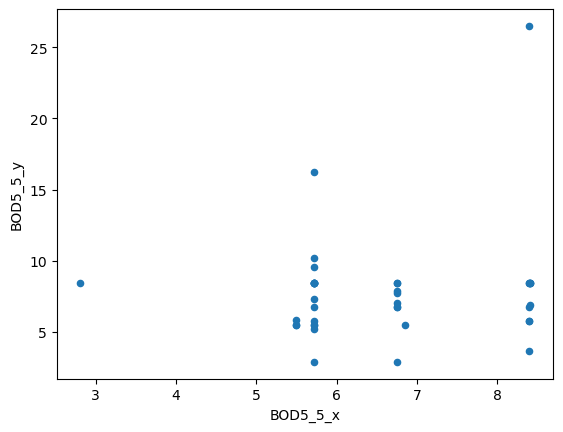

In [38]:
possible_replacement[["BOD5_5_x", "BOD5_5_y"]].plot.scatter(x="BOD5_5_x", y="BOD5_5_y")

In [39]:
possible_replacement = possible_replacement.drop(possible_replacement[(possible_replacement["BOD5_5_y"] > 15) | (possible_replacement["BOD5_5_x"] < 5)].index)

<Axes: xlabel='O2_2_x', ylabel='O2_2_y'>

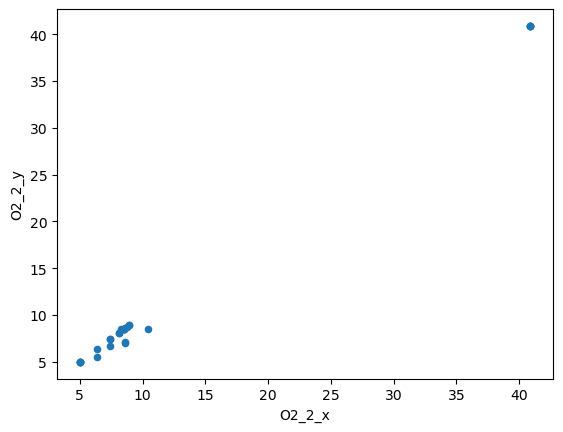

In [40]:
possible_replacement.loc[abs(possible_replacement["O2_2_x"] - possible_replacement["O2_2_y"]) < 2, ["O2_2_x", "O2_2_y"]].plot.scatter(x="O2_2_x", y="O2_2_y")

In [41]:
possible_replacement = possible_replacement.drop(possible_replacement.loc[abs(possible_replacement["O2_2_x"] - possible_replacement["O2_2_y"]) > 2, ["O2_2_x", "O2_2_y"]].index)

In [42]:
possible_replacement = possible_replacement.drop(possible_replacement.loc[abs(possible_replacement["O2_1_x"] - possible_replacement["O2_1_y"]) > 2, ["O2_1_x", "O2_1_y"]].index)#.plot.scatter(x="O2_1_x", y="O2_1_y")

In [43]:
possible_replacement.loc[possible_replacement["O2_1_x"] != possible_replacement["O2_1_y"].round(3), "O2_1_x"] = (
    possible_replacement.loc[possible_replacement["O2_1_x"] != possible_replacement["O2_1_y"].round(3), "O2_1_y"].round(3)
) 

In [44]:
possible_replacement.loc[possible_replacement["O2_2_x"] != possible_replacement["O2_2_y"].round(3), "O2_2_x"] = (
    possible_replacement.loc[possible_replacement["O2_2_x"] != possible_replacement["O2_2_y"].round(3), "O2_2_y"].round(3)
)

In [45]:
possible_replacement["BOD5_5_x"] = possible_replacement["BOD5_5_y"]

In [46]:
possible_replacement = possible_replacement.drop(["O2_1_y", "O2_2_y", "BOD5_5_y"], axis=1)

In [47]:
possible_replacement.set_index("index", inplace=True)
possible_replacement.columns = df_nice.columns

In [48]:
possible_replacement.index.get_loc(1078)

slice(2, 4, None)

In [49]:
to_append = possible_replacement.iloc[3].copy()

In [50]:
# to_append2 = possible_replacement.iloc[[11, 4]].copy()

In [51]:
possible_replacement.iloc[[3]] = None

In [52]:
df_nice[df_nice.index.isin(possible_replacement.index)] = possible_replacement.dropna()

In [53]:
df_nice.loc[3476] = to_append
# df_nice.loc[3477] = to_append2.iloc[0]
# df_nice.loc[3478] = to_append2.iloc[1]

In [54]:
# df_nice.drop("Duplicates", axis=1).to_csv("More variance injected from org data to someones 29 submission.csv", index=False)

In [119]:
# import PCA
from sklearn.decomposition import PCA
# import StandardScaler
from sklearn.preprocessing import StandardScaler


In [205]:
scaler = StandardScaler().fit(df_nice.drop(["Duplicates", "Outliers"], axis=1))
pca = PCA(n_components=3).fit(scaler.transform(df_nice.drop(["Duplicates", "Outliers"], axis=1)))

In [206]:
np.diag(pca.get_covariance())

array([0.01736031, 0.8021677 , 0.67699151, 0.9492564 , 0.01736031,
       0.01736031, 0.01736031, 0.01736031, 0.01736031, 0.01736031,
       0.01736031, 0.01736031, 0.01736031, 0.01736031, 0.01736031,
       0.01736031, 0.01736031, 0.01736031, 0.01736031, 0.01736031,
       0.01736031, 0.01736031, 0.01736031, 0.01736031, 0.01736031,
       0.01736031, 0.01736031, 0.01736031, 0.01736031, 0.01736031,
       0.01736031, 0.01736031, 0.01736031, 0.01736031, 0.99984479,
       0.01736031, 0.01736031])

In [212]:
# # SGD nu 50 vs 55
# clf = SGDOneClassSVM(nu=0.55, random_state=random_state).fit(df.drop(['id'],axis=1))
# # print("SGDOneClassSVM PARAMS: ", clf.get_params())
# df = df[~(clf.predict(df.drop(['id'], axis=1)) == -1)]

# # IsolationForest
# izof = IsolationForest(random_state=0).fit(df.drop(['id'],axis=1))
# df = df[~(izof.predict(df.drop(['id'], axis=1)) == -1)]

# clf = SGDOneClassSVM(nu=0.05, random_state=42).fit(df_nice)
izof = IsolationForest(random_state=0, contamination=0.005).fit(df.drop(['id'],axis=1))
# lof = LocalOutlierFactor(n_neighbors=7, contamination=0.01)
df_nice["Outliers"] = izof.fit_predict(df_nice)




/home/lazydart/miniconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/home/lazydart/miniconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [213]:
df_nice["Outliers"].value_counts()

Outliers
 1    3459
-1      18
Name: count, dtype: int64

In [214]:
df_nice[df_nice["Outliers"] == 1].drop(["Outliers", "Duplicates"], axis=1).to_csv("Tiny_cleaning.csv", index=False)

In [215]:
pca.explained_variance_ratio_

array([0.38890662, 0.25055517, 0.21301799])

/home/lazydart/miniconda3/envs/tensorflow/lib/python3.11/site-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


<Axes: xlabel='0', ylabel='1'>

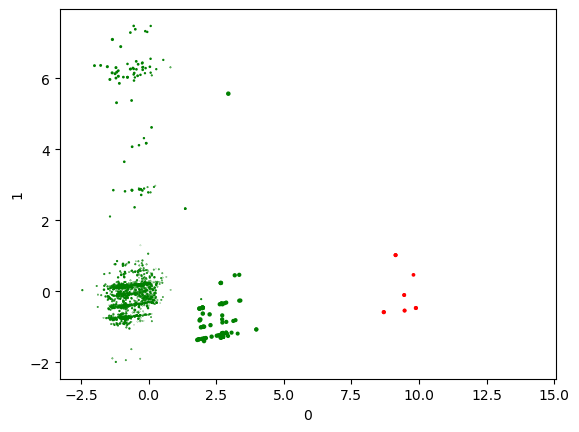

In [216]:
pd.DataFrame(pca.transform(scaler.transform(df_nice.drop(["Outliers", "Duplicates"], axis=1)))).plot.scatter(x=0, y=1, s=2, c=df_nice["Outliers"].transform(lambda x: "r" if x == -1 else "g"))

In [95]:
clean_workflow(df_nice.drop("Duplicates", axis=1), random_state=42)#.to_csv("Double Cleaning Someones solution.csv", index=False)

### EDA

<Axes: >

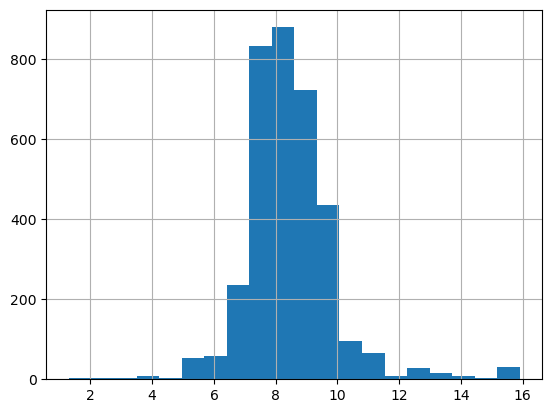

In [56]:
df[df.target.between(0, 18)].target.hist(bins=20)

In [57]:
# The correlation improved after removing weird values
df.loc[:, df.columns.str.contains("^O2") | (df.columns == "target")].corr()**2

,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7
target,1.000000,0.231457,0.049617,0.003487,0.001264,0.000023,0.004640,0.003400
O2_1,0.231457,1.000000,0.041924,0.007360,0.001032,0.000152,0.003248,0.001309
O2_2,0.049617,0.041924,1.000000,0.000207,0.000911,0.000956,0.007790,0.001552
O2_3,0.003487,0.007360,0.000207,1.000000,0.060618,0.013692,0.037074,0.012066
O2_4,0.001264,0.001032,0.000911,0.060618,1.000000,0.021242,0.003477,0.000260
O2_5,0.000023,0.000152,0.000956,0.013692,0.021242,1.000000,0.000626,0.008014
O2_6,0.004640,0.003248,0.007790,0.037074,0.003477,0.000626,1.000000,0.036739
O2_7,0.003400,0.001309,0.001552,0.012066,0.000260,0.008014,0.036739,1.000000


<Axes: >

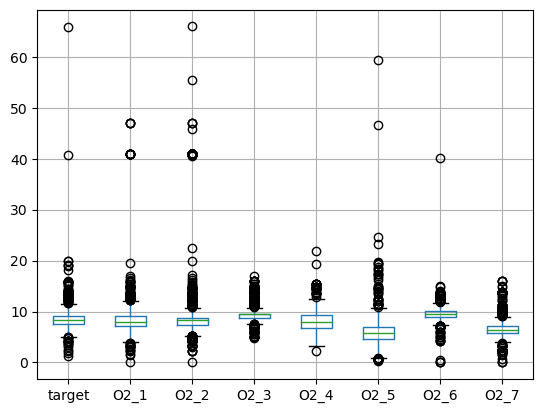

In [58]:
# Display the boxplot
df.loc[:, df.columns.str.contains("^O2") | (df.columns == "target")].boxplot()

<Axes: >

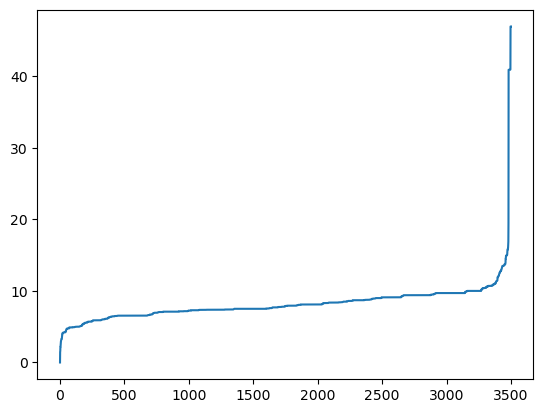

In [59]:
df["O2_1"].sort_values().reset_index(drop=True).plot()

In [60]:
# molecules = [#"^O2", "NH4", "NO2", "NO3", 
#              "BOD5"]


# # for molecule in molecules:
# #     print(molecule)
# #     df = df.copy()
# #     df.loc[:, df.columns.str.contains(molecule + "_3")] = df.loc[:, df.columns.str.contains(molecule)].mean(axis=1)
# #     # model = evaluation_workflow(df)
# #     # pd.DataFrame(model.feature_importances_, index=df.drop("target", axis=1).columns, columns=["Importance"]).sort_values(by="Importance", ascending=False).plot(kind="bar", figsize=(5, 5))


<Axes: xlabel='target', ylabel='BOD5_5'>

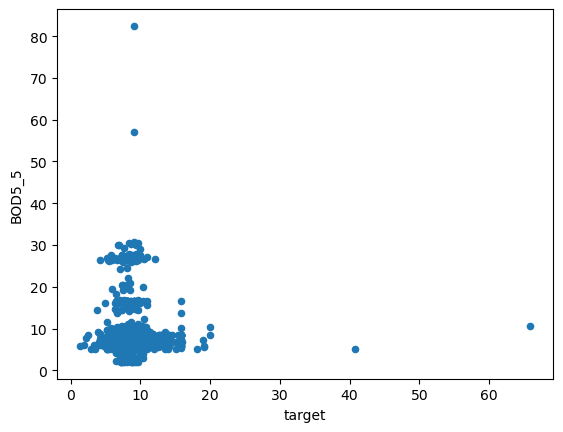

In [61]:
df[["target", "BOD5_5"]].plot.scatter(x="target", y="BOD5_5")

In [62]:
X_train = df.copy()#[df.target.apply(lambda x: x if (x > 7) and (x < 20) else np.nan).isna() == False].copy()

y_train = X_train.pop('target')

rf = RandomForestRegressor(
           n_estimators=1000,
           max_depth=7,
           n_jobs=-1,
           random_state=42)

rf.fit(X_train.iloc[idx_tr], y_train.iloc[idx_tr])

NameError: name 'idx_tr' is not defined

<Axes: >

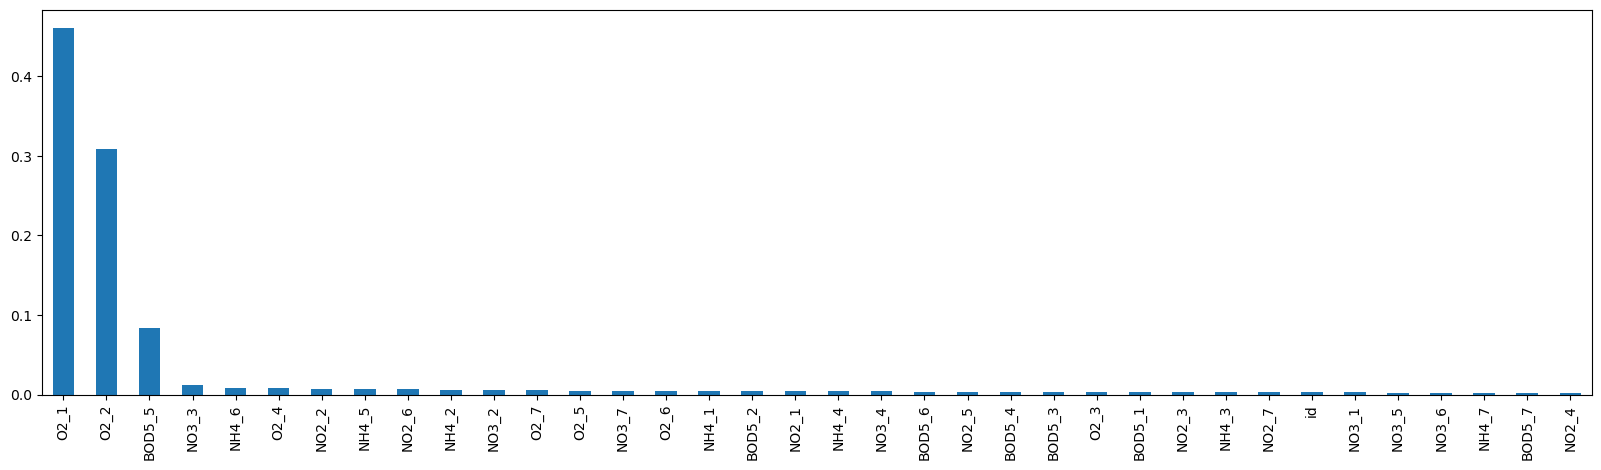

In [ ]:
pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False).plot(kind="bar", figsize=(20, 5))

<Axes: >

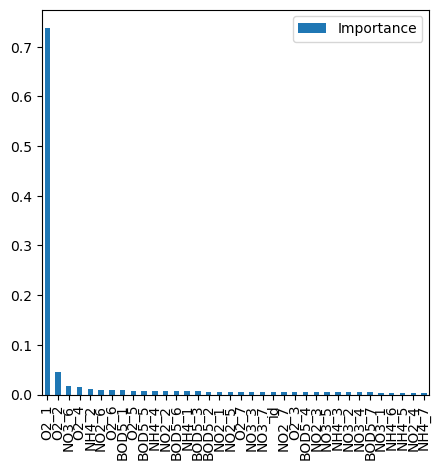

In [ ]:
pd.DataFrame(model.feature_importances_, index=df.drop("target", axis=1).columns, columns=["Importance"]).sort_values(by="Importance", ascending=False).plot(kind="bar", figsize=(5, 5))

In [ ]:
overall_result = []
X_train = df[df.target.apply(lambda x: x if (x > 7) and (x < 20) else np.nan).isna() == False].copy()
y_train = X_train.pop('target')
kf = KFold(shuffle=True, random_state=2)
for fold, (idx_tr, idx_va) in enumerate(kf.split(X_train)):
    rf = RandomForestRegressor(
           n_estimators=1000,
           max_depth=7,
           n_jobs=-1,
           random_state=42)

    rf.fit(X_train.iloc[idx_tr], y_train.iloc[idx_tr])

    result = permutation_importance(rf,
                                    X_train.iloc[idx_va],
                                    y_train.iloc[idx_va],
                                    scoring='neg_root_mean_squared_error',
                                    n_repeats=20,
                                    random_state=1)

    important_features = pd.Series(result['importances_mean'],
                                   index=X_train.columns,
                                   name='feature importance').sort_values(ascending=False)

    overall_result.append(important_features)
    # display(important_features.round(4))

In [ ]:
best_features = pd.concat(overall_result, axis=1).mean(axis=1).sort_values(ascending=False).iloc[:21].index

In [ ]:
pd.concat(overall_result, axis=1).mean(axis=1).sort_values(ascending=False).iloc[:30] # 20 rounds + (7, 20) Clip

O2_1      0.682131
O2_2      0.014963
NO3_3     0.010458
O2_4      0.007079
NO2_2     0.002920
NO3_7     0.001533
NH4_2     0.001100
NO3_2     0.001039
NH4_1     0.000915
BOD5_3    0.000746
O2_3      0.000729
NH4_7     0.000701
NH4_6     0.000634
O2_7      0.000489
NH4_5     0.000420
NO2_4     0.000395
NH4_3     0.000373
BOD5_1    0.000281
NO3_4     0.000183
NO2_3     0.000150
NO3_5    -0.000106
NO3_1    -0.000147
NO2_6    -0.000179
BOD5_4   -0.000259
NH4_4    -0.000301
BOD5_2   -0.000382
NO2_5    -0.000420
O2_6     -0.000544
id       -0.000724
NO2_7    -0.000872
dtype: float64

In [ ]:
cross_validate_model(lambda x: x, "with NH3_3 Replacement")

2400    2400
1737    1737
585      585
3337    3337
2306    2306
Name: id, dtype: int64
# Fold 0 RMSE: 1.075
316      316
3346    3346
2082    2082
924      924
282      282
Name: id, dtype: int64
# Fold 1 RMSE: 1.582
465      465
1876    1876
2850    2850
2365    2365
1776    1776
Name: id, dtype: int64
# Fold 2 RMSE: 1.148
3440    3440
642      642
1584    1584
800      800
1866    1866
Name: id, dtype: int64
# Fold 3 RMSE: 1.120
451      451
3366    3366
1530    1530
1          1
1987    1987
Name: id, dtype: int64
# Fold 4 RMSE: 2.281
# Overall RMSE: 1.512 with NH3_3 Replacement


In [ ]:
pd.concat(overall_result, axis=1).mean(axis=1).sort_values(ascending=False).iloc[:30] # 20 rounds

O2_1      0.719740
O2_2      0.018441
O2_4      0.006435
NO2_2     0.002779
BOD5_3    0.001625
NH4_2     0.001591
NH4_1     0.001498
NH4_3     0.001214
NO3_5     0.001176
NO3_4     0.000983
NO2_4     0.000790
NO3_7     0.000750
NH4_5     0.000711
NO2_6     0.000708
BOD5_1    0.000473
NH4_6     0.000281
BOD5_4    0.000099
BOD5_2    0.000012
O2_7     -0.000089
NO3_2    -0.000123
BOD5_7   -0.000134
O2_3     -0.000144
O2_5     -0.000147
NH4_7    -0.000162
NO2_5    -0.000187
NO3_3    -0.000194
id       -0.000258
NO3_1    -0.000281
BOD5_5   -0.000288
NO2_7    -0.000594
dtype: float64

In [ ]:
pd.concat(overall_result, axis=1).mean(axis=1).sort_values(ascending=False).iloc[:30]

O2_1      0.714822
O2_2      0.016988
O2_4      0.006335
NO2_2     0.002349
NH4_2     0.002122
BOD5_3    0.001446
NH4_1     0.001351
NO3_4     0.000887
NH4_3     0.000864
NH4_5     0.000745
NO3_7     0.000717
NO2_6     0.000664
NO2_4     0.000657
BOD5_2    0.000435
NO3_5     0.000334
NH4_6     0.000176
BOD5_1    0.000134
BOD5_4    0.000117
NH4_7     0.000093
NO3_2     0.000021
O2_3      0.000007
id       -0.000022
NO3_1    -0.000088
O2_5     -0.000374
NO2_5    -0.000376
BOD5_7   -0.000389
NO2_3    -0.000394
NO3_3    -0.000401
BOD5_5   -0.000466
O2_7     -0.000474
dtype: float64

In [ ]:
zero_given_columns(df, column_to_zero)

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,...,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
0,0,8.59,7.500,9.000,0.0,9.265,0.0,0.0,0.0,0.180,...,0.0,0.0,0.0,0.0,0.0,10.665,0.0,0.0,0.0,0.0
1,0,9.10,13.533,40.900,0.0,9.265,0.0,0.0,0.0,1.107,...,0.0,0.0,0.0,0.0,0.0,2.040,0.0,0.0,0.0,0.0
2,0,8.21,3.710,5.420,0.0,9.265,0.0,0.0,0.0,0.020,...,0.0,0.0,0.0,0.0,0.0,4.725,0.0,0.0,0.0,0.0
3,0,8.39,8.700,8.100,0.0,9.200,0.0,0.0,0.0,0.280,...,0.0,0.0,0.0,0.0,0.0,3.500,0.0,0.0,0.0,0.0
4,0,8.07,8.050,8.650,0.0,9.265,0.0,0.0,0.0,0.360,...,0.0,0.0,0.0,0.0,0.0,3.950,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,0,8.08,6.250,8.300,0.0,9.265,0.0,0.0,0.0,0.565,...,0.0,0.0,0.0,0.0,0.0,2.800,0.0,0.0,0.0,0.0
3496,0,8.09,6.630,6.630,0.0,7.600,0.0,0.0,0.0,1.300,...,0.0,0.0,0.0,0.0,0.0,2.040,0.0,0.0,0.0,0.0
3497,0,9.95,8.367,8.433,0.0,6.170,0.0,0.0,0.0,0.430,...,0.0,0.0,0.0,0.0,0.0,4.725,0.0,0.0,0.0,0.0
3498,0,9.52,10.000,6.630,0.0,9.265,0.0,0.0,0.0,0.300,...,0.0,0.0,0.0,0.0,0.0,4.725,0.0,0.0,0.0,0.0


In [ ]:
cross_validate_model(lambda x: zero_given_columns(x[x.target.apply(lambda x: x if (x > 3) and (x < 20) else np.nan).isna() == False], column_to_zero), f"Select {i} Best Features with (3, 20) clip")

In [ ]:
for i in range(len(best_features), 0, -1):
    column_to_zero = df.columns[~(df.columns.isin(best_features[:i]) | (df.columns == "target"))]
    cross_validate_model(lambda x: zero_given_columns(x[x.target.apply(lambda x: x if (x > 7) and (x < 20) else np.nan).isna() == False], column_to_zero), f"Select {i} Best Features with (7, 20) clip")

# Fold 0 RMSE: 1.150
# Fold 1 RMSE: 1.060
# Fold 2 RMSE: 1.066
# Fold 3 RMSE: 1.004
# Fold 4 RMSE: 2.762
# Overall RMSE: 1.563 Select 21 Best Features with (7, 20) clip
# Fold 0 RMSE: 1.151
# Fold 1 RMSE: 1.065
# Fold 2 RMSE: 1.065
# Fold 3 RMSE: 1.004
# Fold 4 RMSE: 2.761
# Overall RMSE: 1.564 Select 20 Best Features with (7, 20) clip
# Fold 0 RMSE: 1.149
# Fold 1 RMSE: 1.062
# Fold 2 RMSE: 1.064
# Fold 3 RMSE: 1.002
# Fold 4 RMSE: 2.758
# Overall RMSE: 1.561 Select 19 Best Features with (7, 20) clip
# Fold 0 RMSE: 1.146
# Fold 1 RMSE: 1.062
# Fold 2 RMSE: 1.064
# Fold 3 RMSE: 1.001
# Fold 4 RMSE: 2.758
# Overall RMSE: 1.561 Select 18 Best Features with (7, 20) clip
# Fold 0 RMSE: 1.146
# Fold 1 RMSE: 1.061
# Fold 2 RMSE: 1.065
# Fold 3 RMSE: 1.000
# Fold 4 RMSE: 2.756
# Overall RMSE: 1.560 Select 17 Best Features with (7, 20) clip
# Fold 0 RMSE: 1.143
# Fold 1 RMSE: 1.064
# Fold 2 RMSE: 1.067
# Fold 3 RMSE: 1.001
# Fold 4 RMSE: 2.759
# Overall RMSE: 1.562 Select 16 Best Features with

In [ ]:
column_to_zero = df.columns[~(df.columns.isin(best_features[:11]) | (df.columns == "target"))]

In [ ]:
cross_validate_model(lambda x: zero_given_columns(x[x.target.apply(lambda x: x if (x > 3) and (x < 18) else np.nan).isna() == False].copy(), column_to_zero), "Test")#.to_csv("submission.csv", index=False)

# Fold 0 RMSE: 1.112
# Fold 1 RMSE: 0.966
# Fold 2 RMSE: 0.995
# Fold 3 RMSE: 0.979
# Fold 4 RMSE: 2.736
# Overall RMSE: 1.523 Test


In [ ]:
all_experimental_results = pd.DataFrame(map(lambda x: pd.Series(x[1:], name=x[0]), result_list))

In [ ]:
all_experimental_results.T.apply(lambda x: np.sqrt((x**2).mean())).nsmallest(5)#.sort_values(by="Overall RMSE")

Test                                         1.523444
Select 11 Best Features with (3, 20) clip    1.526049
Test                                         1.526049
Select 12 Best Features with (3, 20) clip    1.526403
Select 10 Best Features with (3, 20) clip    1.526895
dtype: float64

In [ ]:
anomaly_score = IsolationForest(contamination=0.005).fit_predict(df[["target","O2_2", "O2_3"]])

/home/lazydart/miniconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


<Axes: xlabel='O2_2', ylabel='O2_3'>

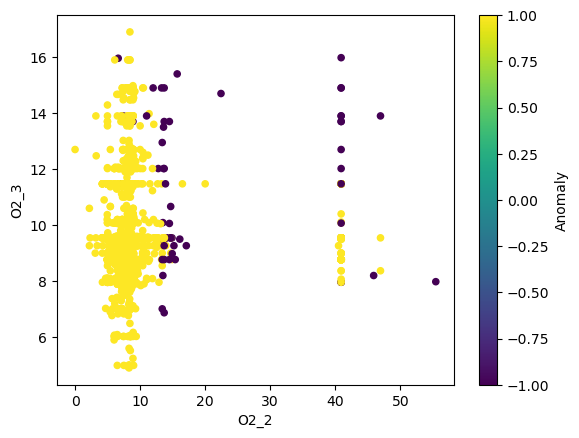

In [ ]:
df[["O2_2", "O2_3", "Anomaly"]].plot.scatter(x="O2_2", y="O2_3", c="Anomaly", cmap="viridis")

In [ ]:
df.loc[(df["O2_2"] > 30) & (df["O2_3"] < 30), "O2_2"] = df.loc[(df["O2_2"] > 30) & (df["O2_3"] < 30), "O2_3"] 

In [ ]:
df.loc[(df["O2_1"] > 30) & (df["O2_2"] < 30), "O2_1"] = df.loc[(df["O2_1"] > 30) & (df["O2_2"] < 30), "O2_2"] 

In [ ]:
df.loc[(df["O2_2"] > 30) & (df["O2_1"] < 30), "O2_2"] = df.loc[(df["O2_2"] > 30) & (df["O2_1"] < 30), "O2_1"] 

<Axes: >

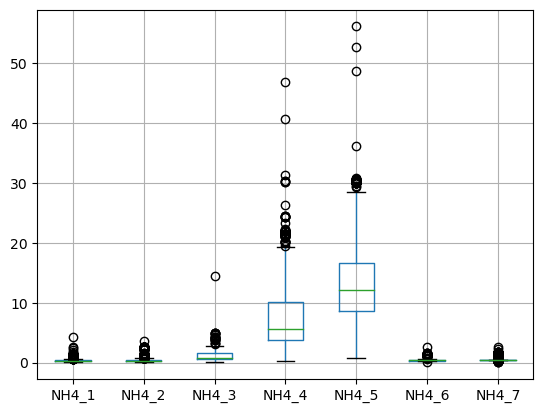

In [ ]:
df.loc[:,df.columns.str.contains("NH4")].drop(2662).boxplot()

In [ ]:
df.to_csv("submission.csv", index=False)